In [ ]:
pip install yfinance

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
      --------------------------------------- 0.0/3.0 MB 281.8 kB/s eta 0:00:11
      --------------------------------------- 0.0/3.0 MB 281.8 kB/s eta 0:00:11
      --------------------------------------- 0.0/3.0 MB 281.8 kB/s eta 0:00:11
     - -------------------------------------- 0.1/3.0 MB 514.3 kB/s eta 0:00:06
     - -------------------------------------- 0.1/3.0 MB 514.3 kB/s eta 0:00:06
     - -------------------------------------- 0.1/3.0 MB 514.3 kB/s eta 0:00:06
     -- ------------------------------------- 0.2/3.0 MB 518.8 kB/s eta 0:00:06
     -- ------------------------------------- 0.2/3.0 MB 518.8 kB/s eta 0:00:06
     -- ------------------------------------- 0.2/3.0 MB 518.8 kB/s eta 0:00:


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Download Tesla's historical stock data for the past 3 years
ticker = 'TSLA'
start_date = '2020-03-09'
end_date = '2025-03-09'
df_original = yf.download(ticker, start=start_date, end=end_date)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Save to Excel file
df_original.to_excel('output_raw.xlsx', sheet_name='Tesla Stock Data')

In [ ]:
df_original.head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-03-09,40.533333,44.200001,40.333332,40.359333,256105500
2020-03-10,43.021999,44.533333,40.533333,43.962002,233916000
2020-03-11,42.282001,43.571999,40.866669,42.680000,199837500
2020-03-12,37.369999,39.633331,36.416668,38.726002,283636500
2020-03-13,36.441334,40.504665,33.466667,39.666668,339604500


In [ ]:
df = df_original.copy()

In [ ]:
# Remove the Ticker level (if the DataFrame has a MultiIndex in columns)
df.columns = df.columns.droplevel('Ticker')

# Verify the updated structure
print(df.head())
print(df.columns)


Price           Close       High        Low       Open     Volume
Date                                                             
2020-03-09  40.533333  44.200001  40.333332  40.359333  256105500
2020-03-10  43.021999  44.533333  40.533333  43.962002  233916000
2020-03-11  42.282001  43.571999  40.866669  42.680000  199837500
2020-03-12  37.369999  39.633331  36.416668  38.726002  283636500
2020-03-13  36.441334  40.504665  33.466667  39.666668  339604500
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [ ]:
# Function to fill NaNs with the average of the row above and below
def fill_nan_with_neighbors(df):
    for col in df.columns:
        df[col] = df[col].mask(df[col].isna(), (df[col].shift(1) + df[col].shift(-1)) / 2)
    return df

# Apply to the dataset before analysis
df = fill_nan_with_neighbors(df)


In [ ]:
# Calculate Simple Moving Averages (SMA)
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()


In [ ]:
# Calculate Exponential Moving Averages (EMA)
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()


In [ ]:
# Calculate RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))


In [ ]:
# Calculate Average True Range (ATR)
true_range = pd.DataFrame()
# Calculate True Range
true_range["high_low"] = df['High'] - df['Low']
true_range["high_close"] = (df['High'] - df['Close'].shift()).abs()
true_range["low_close"] = (df['Low'] - df['Close'].shift()).abs()
# Calculate ATR
df['ATR'] = true_range.max(axis=1).rolling(window=14).mean()

In [ ]:
# Calculate MACD (12-day EMA - 26-day EMA) and Signal Line (9-day EMA of MACD)
df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
# Calculate Bollinger Bands (20-day SMA ± 2 std dev)
# Calculate the rolling mean (middle Bollinger Band)
df['Bollinger_Mid'] = df['Close'].rolling(window=20).mean()

# Ensure the rolling standard deviation is treated as a Series
rolling_std = df['Close'].rolling(window=20).std().squeeze()

# Calculate the upper and lower Bollinger Bands with proper alignment
df['Bollinger_Upper'] = df['Bollinger_Mid'] + (rolling_std * 2)
df['Bollinger_Lower'] = df['Bollinger_Mid'] - (rolling_std * 2)


In [ ]:
# Calculate VWAP (Cumulative Volume-Weighted Average Price)
df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

# Calculate Candle Width (Close - Open)
df['Candle_Width'] = df['Close'] - df['Open']

# Calculate Daily % Change
df['% Change'] = df['Close'].pct_change() * 100

# Calculate On-Balance Volume (OBV)
df['OBV'] = (df['Volume'] * ((df['Close'] - df['Close'].shift()) >= 0).astype(int) * 2 - 1).cumsum()

# Calculate Cumulative Returns
df['Cumulative_Return'] = (1 + df['% Change'] / 100).cumprod() - 1

# Calculate Sharpe Ratio (assuming a 1% risk-free rate)
rf_rate = 0.01  # Example: 1% risk-free rate
df['Daily_Return'] = df['% Change'] / 100
excess_return = df['Daily_Return'] - rf_rate / 252
sharpe_ratio = excess_return.mean() / excess_return.std() * (252 ** 0.5)




In [ ]:
# Select relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume',
         'SMA_5', 'SMA_20', 'SMA_50', 'SMA_200',
         'EMA_5', 'EMA_20', 'EMA_50', 'EMA_200',
         'RSI', 'ATR', 'MACD', 'MACD_Signal',
         'Bollinger_Upper', 'Bollinger_Mid', 'Bollinger_Lower',
         'VWAP', 'Candle_Width', '% Change', 'OBV', 'Cumulative_Return']]

In [ ]:
df.head()

Price,Open,High,Low,Close,Volume,SMA_5,SMA_20,SMA_50,SMA_200,EMA_5,...,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Mid,Bollinger_Lower,VWAP,Candle_Width,% Change,OBV,Cumulative_Return
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-09,40.359333,44.200001,40.333332,40.533333,256105500,NaN,NaN,NaN,NaN,40.533333,...,0.000000,0.000000,NaN,NaN,NaN,40.533333,0.174000,NaN,-1,NaN
2020-03-10,43.962002,44.533333,40.533333,43.021999,233916000,NaN,NaN,NaN,NaN,41.362888,...,0.198526,0.039705,NaN,NaN,NaN,41.721319,-0.940002,6.139802,467831998,0.061398
2020-03-11,42.680000,43.571999,40.866669,42.282001,199837500,NaN,NaN,NaN,NaN,41.669259,...,0.292773,0.090319,NaN,NaN,NaN,41.883737,-0.397999,-1.720045,467831997,0.043141
2020-03-12,38.726002,39.633331,36.416668,37.369999,283636500,NaN,NaN,NaN,NaN,40.236173,...,-0.028564,0.066542,NaN,NaN,NaN,40.568620,-1.356003,-11.617242,467831996,-0.078043
2020-03-13,39.666668,40.504665,33.466667,36.441334,339604500,39.929733,NaN,NaN,NaN,38.971226,...,-0.354080,-0.017582,NaN,NaN,NaN,39.501188,-3.225334,-2.485055,467831995,-0.100954


In [ ]:
df.to_excel('output_with_nan.xlsx', sheet_name='Tesla Stock Data')

In [ ]:
# Drop the first 200 rows and reset the index
df = df.iloc[200:]

In [ ]:
# Save to Excel file
df.to_excel('output.xlsx', sheet_name='Tesla Stock Data')


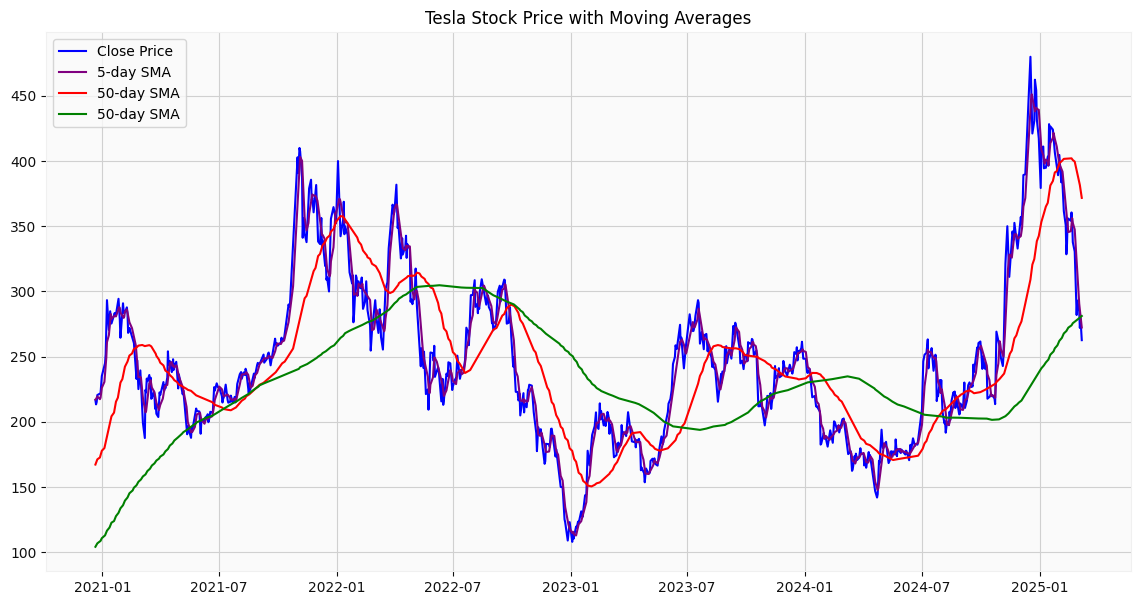

Sharpe Ratio: 0.884543625075115


In [ ]:
# Plot Close Price and Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['SMA_5'], label='5-day SMA', color='purple')
plt.plot(df['SMA_50'], label='50-day SMA', color='red')
plt.plot(df['SMA_200'], label='50-day SMA', color='green')

plt.title('Tesla Stock Price with Moving Averages')
plt.legend(loc='best')
plt.show()

# Print Sharpe Ratio
print(f'Sharpe Ratio: {sharpe_ratio}')


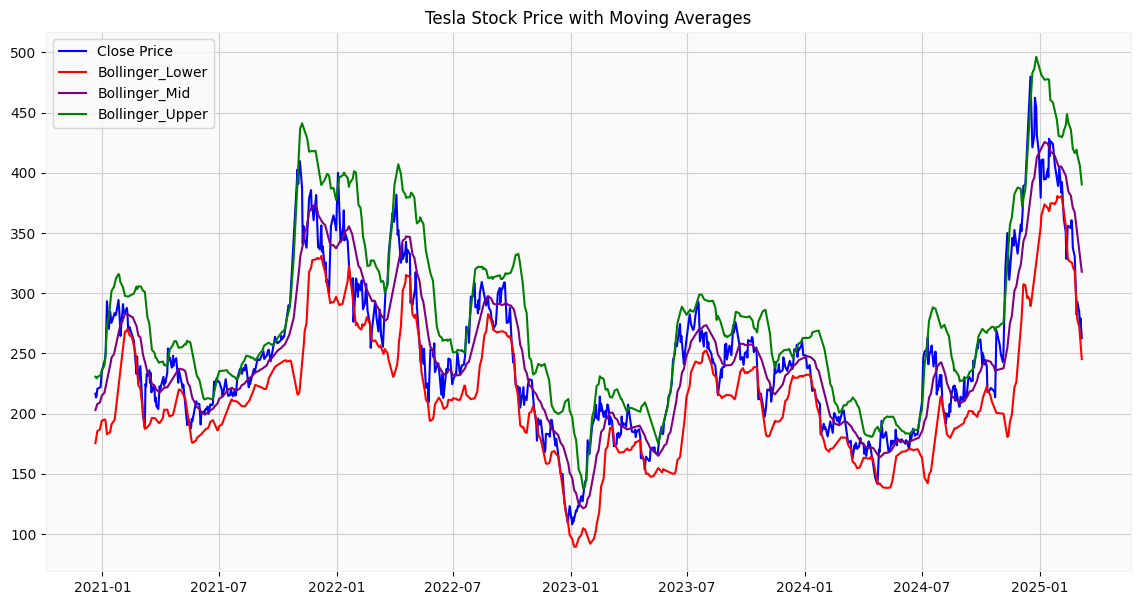

In [ ]:
# Plot Close Price and Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue')

plt.plot(df['Bollinger_Lower'], label='Bollinger_Lower', color='red')
plt.plot(df["Bollinger_Mid"], label='Bollinger_Mid', color='purple')
plt.plot(df["Bollinger_Upper"], label='Bollinger_Upper', color='green')

plt.title('Tesla Stock Price with Moving Averages')
plt.legend(loc='best')
plt.show()

In [ ]:
pip install mplfinance


   ---------------------------------------- 0.0/75.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/75.0 kB ? eta -:--:--
   ---------- ----------------------------- 20.5/75.0 kB 217.9 kB/s eta 0:00:01
   ---------------- ----------------------- 30.7/75.0 kB 325.1 kB/s eta 0:00:01
   --------------------- ------------------ 41.0/75.0 kB 279.3 kB/s eta 0:00:01
   -------------------------------------- - 71.7/75.0 kB 391.3 kB/s eta 0:00:01
   ---------------------------------------- 75.0/75.0 kB 376.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
print(df.dtypes)  # Check column data types
print(df['Open'].apply(type).unique())  # Check data types in "Open" column


Price
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                 int64
SMA_5                float64
SMA_20               float64
SMA_50               float64
SMA_200              float64
EMA_5                float64
EMA_20               float64
EMA_50               float64
EMA_200              float64
RSI                  float64
ATR                  float64
MACD                 float64
MACD_Signal          float64
Bollinger_Upper      float64
Bollinger_Mid        float64
Bollinger_Lower      float64
VWAP                 float64
Candle_Width         float64
% Change             float64
OBV                    int64
Cumulative_Return    float64
dtype: object
[<class 'float'>]


In [ ]:
df

Price,Open,High,Low,Close,Volume,SMA_5,SMA_20,SMA_50,SMA_200,EMA_5,...,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Mid,Bollinger_Lower,VWAP,Candle_Width,% Change,OBV,Cumulative_Return
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-21,222.080002,222.833328,215.356674,216.619995,174135900,217.118665,203.006332,167.323466,104.309070,217.853007,...,15.775130,15.609507,230.612636,203.006332,175.400027,97.363722,-5.460007,-6.494968,48408041799,4.344243
2020-12-22,216.000000,216.626663,204.743332,213.446671,155148000,217.591333,204.981165,168.643733,105.161193,216.384228,...,14.865514,15.460709,229.289465,204.981165,180.672865,97.791694,-2.553329,-1.464927,48408041798,4.265954
2020-12-23,210.733337,217.166672,207.523331,215.326660,99519000,219.138666,206.491165,169.972599,106.026416,216.031705,...,14.133414,15.195250,229.312992,206.491165,183.669339,98.068992,4.593323,0.880777,48607079797,4.312335
2020-12-24,214.330002,222.029999,213.666672,220.589996,68596800,219.529999,207.953999,171.309066,106.942516,217.551136,...,13.818635,14.919927,230.432944,207.953999,185.475053,98.267914,6.259995,2.444350,48744273396,4.442187
2020-12-28,224.836670,227.133331,220.266663,221.229996,96835800,217.442664,209.252832,172.741133,107.866460,218.777422,...,13.465590,14.629059,231.643596,209.252832,186.862068,98.549093,-3.606674,0.290131,48937944995,4.457977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-03,300.339996,303.940002,277.299988,284.649994,115551400,290.635999,340.404999,385.712399,279.327950,295.603218,...,-26.520717,-20.434344,408.259030,340.404999,272.550967,199.157646,-15.690002,-2.843203,159055049147,6.022615
2025-03-04,270.929993,284.350006,261.839996,272.040009,126706600,284.484003,334.823000,381.555999,279.800400,287.748815,...,-28.172918,-21.982059,405.975435,334.823000,263.670564,199.220559,1.110016,-4.429997,159055049146,5.711513
2025-03-05,272.920013,279.549988,267.709991,279.100006,94042900,282.144006,329.167500,378.335399,280.325950,284.865879,...,-28.583128,-23.302273,399.084398,329.167500,259.250603,199.271703,6.179993,2.595206,159243134945,5.885691


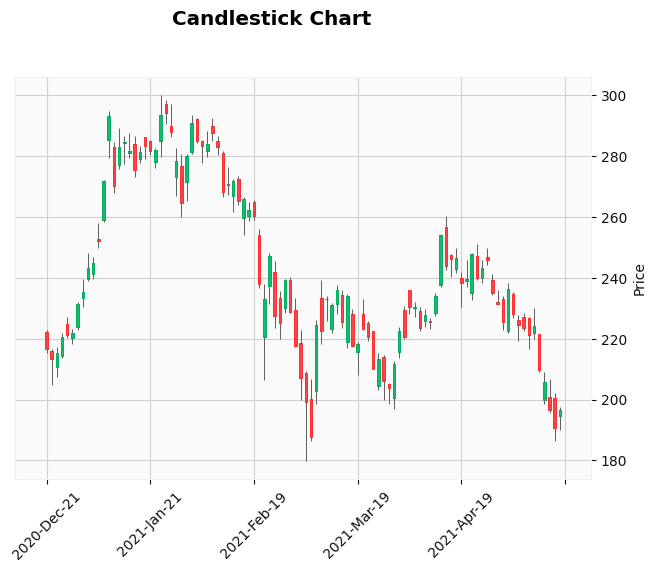

In [ ]:
import mplfinance as mpf

# Plotting the candlestick chart
mpf.plot(df.iloc[0:100, 0:5], type='candle', title='Candlestick Chart', style='yahoo')


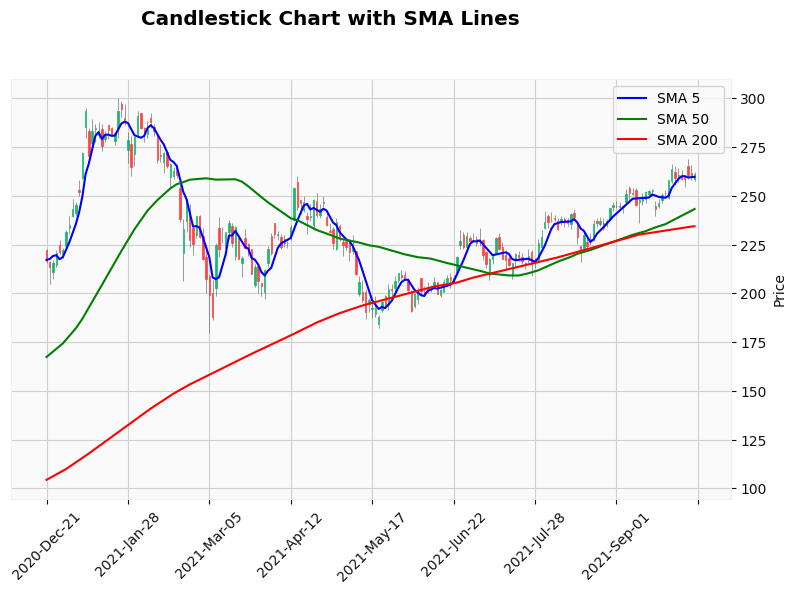

In [ ]:
add_sma_5 = mpf.make_addplot(df.iloc[0:200]['SMA_5'], color='blue', width=1.5, label='SMA 5')
add_sma_50 = mpf.make_addplot(df.iloc[0:200]['SMA_50'], color='green', width=1.5, label='SMA 50')
add_sma_200 = mpf.make_addplot(df.iloc[0:200]['SMA_200'], color='red', width=1.5, label='SMA 200')

# Plot the candlestick chart with the SMAs
mpf.plot(df.iloc[0:200, 0:5], type='candle', addplot=[add_sma_5, add_sma_50, add_sma_200],
         title='Candlestick Chart with SMA Lines', style='yahoo', figsize=(10, 6))
